In [1]:
%config IPCompleter.use_jedi = False

In [2]:
import pandas as pd
from pathlib import Path

## Load and Clean

In [3]:
data_path = Path('.') / 'data' / 'raw' / 'sent'
data_path.exists()

True

In [4]:
driver_files = list(data_path.glob('driver*.csv'))
team_files = list(data_path.glob('team*.csv'))

In [5]:
def load_from_files(files):
    df = pd.concat([pd.read_csv(f, sep='|').dropna() for f in files])
    df.drop('Unnamed: 0', axis='columns', inplace=True)
    entity_col = df.columns[0]
    
    # Clean fields that should be numeric
    df = str_to_numeric(df, cols=['Sentiment', 'Current Price', 'Season Start PriceSeason Price'])
    df['ts'] = pd.to_datetime(df['ts'])
    return df[[entity_col, 'ts'] + list(df.columns[1:-1])].sort_values(by=[entity_col, 'ts']).reset_index(drop=True)

In [6]:
def str_to_numeric(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('[\%\$m]', '', regex=True).astype(float)
    return df

In [7]:
drivers = load_from_files(driver_files)
teams = load_from_files(team_files)

In [8]:
drivers

,Driver,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million
0,Alex Albon ALB Williams,2022-06-12 15:42:57,0,0,0,-97.0,7.8,7.5,1.23
1,Alex Albon ALB Williams,2022-06-12 15:52:24,0,0,0,-97.0,7.8,7.5,1.23
2,Alex Albon ALB Williams,2022-06-12 17:10:49,2,1,0,-96.0,7.8,7.5,1.23
3,Alex Albon ALB Williams,2022-06-12 23:24:40,1,0,0,-96.0,7.8,7.5,1.23
4,Alex Albon ALB Williams,2022-06-13 09:07:54,1,0,0,-95.0,7.8,7.5,1.23
...,...,...,...,...,...,...,...,...,...
1415,Yuki Tsunoda TSU AlphaTauri,2022-07-29 22:34:47,-4,-1,0,-59.0,8.3,8.5,0.45
1416,Yuki Tsunoda TSU AlphaTauri,2022-07-30 07:31:19,-7,-5,-2,-65.0,8.3,8.5,0.45
1417,Yuki Tsunoda TSU AlphaTauri,2022-07-31 10:27:56,0,0,0,-77.0,8.3,8.5,0.44
1418,Yuki Tsunoda TSU AlphaTauri,2022-08-02 19:26:41,5,0,0,-74.0,8.3,8.5,0.40


In [9]:
teams

,Team,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million
0,Alfa Romeo,2022-06-12 15:42:57,-6.0,-1.0,0.0,-26.0,8.7,8.0,1.87
1,Alfa Romeo,2022-06-12 15:52:24,-7.0,-2.0,-1.0,-27.0,8.7,8.0,1.87
2,Alfa Romeo,2022-06-12 17:10:49,-6.0,0.0,1.0,-26.0,8.7,8.0,1.87
3,Alfa Romeo,2022-06-12 23:24:40,-3.0,0.0,0.0,-27.0,8.7,8.0,1.87
4,Alfa Romeo,2022-06-13 09:07:54,-3.0,-1.0,0.0,-30.0,8.7,8.0,1.87
...,...,...,...,...,...,...,...,...,...
695,Williams,2022-07-29 22:34:47,-5.0,-2.0,-1.0,-67.0,6.2,7.0,1.33
696,Williams,2022-07-30 07:31:19,-7.0,-3.0,-1.0,-72.0,6.2,7.0,1.33
697,Williams,2022-07-31 10:27:56,-1.0,-1.0,-1.0,-76.0,6.2,7.0,1.25
698,Williams,2022-08-02 19:26:41,26.0,0.0,0.0,-51.0,6.2,7.0,1.33


## Compare

In [10]:
diff_cols = ['ts', '12 Hour', '3 Hour', 'Latest', 'Sentiment', 'Current Price']

In [11]:
drivers_a = drivers.join(drivers.groupby(['Driver'], as_index=False)[diff_cols].diff(), rsuffix=' diff')

In [12]:
teams_a = teams.join(teams.groupby(['Team'], as_index=False)[diff_cols].diff(), rsuffix=' diff')

## Changes

In [13]:
cond_driver_price_change = (drivers_a['Current Price diff'].notna()) & (drivers_a['Current Price diff'] != 0)
drivers_a[cond_driver_price_change].dropna().sort_values(by='ts')

,Driver,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
1214,Sergio Perez PER Red Bull,2022-06-13 16:20:06,1,1,1,1.0,18.3,17.5,1.82,0 days 03:59:51,-9.0,-2.0,1.0,-97.0,0.1
722,Lewis Hamilton HAM Mercedes,2022-06-15 10:22:25,0,0,99,0.0,30.0,31.0,0.65,0 days 23:00:47,99.0,99.0,99.0,99.0,-0.1
302,Fernando Alonso ALO Alpine,2022-06-18 12:31:44,5,5,1,5.0,12.3,12.5,0.64,0 days 04:22:05,-8.0,3.0,-1.0,-88.0,0.1
1155,Sebastian Vettel VET Aston Martin,2022-06-18 14:25:02,54,54,48,54.0,11.5,11.5,0.90,0 days 01:53:18,-1.0,39.0,46.0,1.0,0.1
374,George Russell RUS Mercedes,2022-06-18 14:25:02,15,15,-84,15.0,23.8,24.0,1.31,0 days 01:53:18,22.0,10.0,-85.0,-64.0,0.1
90,Charles Leclerc LEC Ferrari,2022-06-18 14:25:02,-94,-94,-58,-94.0,18.9,18.0,1.66,0 days 01:53:18,-59.0,-88.0,-56.0,-14.0,-0.1
304,Fernando Alonso ALO Alpine,2022-06-18 15:01:00,6,6,-69,6.0,12.4,12.5,0.64,0 days 00:35:58,-69.0,-65.0,-104.0,-69.0,0.1
1014,Pierre Gasly GAS AlphaTauri,2022-06-18 15:01:00,9,9,-90,9.0,13.0,13.5,0.82,0 days 00:35:58,-9.0,-11.0,-103.0,-90.0,0.1
91,Charles Leclerc LEC Ferrari,2022-06-18 15:01:00,-48,-48,46,-48.0,18.8,18.0,1.67,0 days 00:35:58,46.0,46.0,104.0,46.0,-0.1
1157,Sebastian Vettel VET Aston Martin,2022-06-19 09:05:33,0,0,0,2.0,11.6,11.5,0.82,0 days 18:04:33,-96.0,-96.0,-42.0,-94.0,0.1


In [14]:
cond_team_price_change = (teams_a['Current Price diff'].notna()) & (teams_a['Current Price diff'] != 0)
teams_a[cond_team_price_change].dropna()

,Team,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
27,Alfa Romeo,2022-06-21 07:07:51,-3.0,0.0,85.0,-3.0,8.6,8.0,2.07,0 days 09:37:52,1.0,0.0,85.0,88.0,-0.1
38,Alfa Romeo,2022-07-01 17:09:46,1.0,0.0,1.0,1.0,8.5,8.0,2.09,1 days 08:27:56,0.0,-1.0,0.0,88.0,-0.1
163,Alpine,2022-06-20 01:20:07,5.0,1.0,0.0,5.0,14.0,14.0,1.40,0 days 08:06:32,-8.0,-10.0,-3.0,-93.0,0.1
229,Aston Martin,2022-06-18 15:01:00,23.0,23.0,9.0,23.0,11.1,11.5,1.49,0 days 02:29:16,20.0,30.0,8.0,-62.0,0.1
235,Aston Martin,2022-06-20 10:05:56,1.0,1.0,-1.0,1.0,11.2,11.5,1.56,0 days 02:07:08,-73.0,-23.0,-7.0,-94.0,0.1
252,Aston Martin,2022-07-05 08:29:01,-87.0,-87.0,2.0,-87.0,11.1,11.5,1.65,0 days 18:20:57,-87.0,-87.0,3.0,2.0,-0.1
260,Aston Martin,2022-07-10 18:39:38,-1.0,0.0,1.0,-1.0,11.0,11.5,1.64,1 days 02:58:53,0.0,0.0,1.0,96.0,-0.1
369,Haas,2022-06-18 15:01:00,-6.0,-6.0,-2.0,-6.0,6.3,6.0,0.69,0 days 02:29:16,1.0,-5.0,-2.0,93.0,-0.1
407,Haas,2022-07-23 09:09:27,0.0,-4.0,0.0,0.0,6.4,6.0,1.42,1 days 01:48:08,-3.0,-6.0,-1.0,-86.0,0.1
462,Mclaren,2022-07-05 08:29:01,-24.0,-24.0,58.0,-24.0,17.5,18.5,1.06,0 days 18:20:57,-24.0,-24.0,57.0,58.0,-0.1


## Inspection

In [15]:
drivers_a.set_index('Driver').filter(like='Perez', axis=0)

,ts,12 Hour,3 Hour,Latest,Sentiment,Current Price,Season Start PriceSeason Price,Points/Million,ts diff,12 Hour diff,3 Hour diff,Latest diff,Sentiment diff,Current Price diff
Driver,,,,,,,,,,,,,,
Sergio Perez PER Red Bull,2022-06-12 15:42:57,27,7,1,73.0,18.2,17.5,1.83,NaT,NaN,NaN,NaN,NaN,NaN
Sergio Perez PER Red Bull,2022-06-12 15:52:24,30,10,3,76.0,18.2,17.5,1.83,0 days 00:09:27,3.0,3.0,2.0,3.0,0.0
Sergio Perez PER Red Bull,2022-06-12 17:10:49,34,12,4,82.0,18.2,17.5,1.83,0 days 01:18:25,4.0,2.0,1.0,6.0,0.0
Sergio Perez PER Red Bull,2022-06-12 23:24:40,26,1,0,87.0,18.2,17.5,1.83,0 days 06:13:51,-8.0,-11.0,-4.0,5.0,0.0
Sergio Perez PER Red Bull,2022-06-13 09:07:54,9,2,0,95.0,18.2,17.5,1.83,0 days 09:43:14,-17.0,1.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sergio Perez PER Red Bull,2022-07-29 22:34:47,-9,-1,0,24.0,18.2,17.5,1.47,0 days 14:54:15,-16.0,-1.0,0.0,-10.0,0.0
Sergio Perez PER Red Bull,2022-07-30 07:31:19,-21,-17,-6,4.0,18.2,17.5,1.47,0 days 08:56:32,-12.0,-16.0,-6.0,-20.0,0.0
Sergio Perez PER Red Bull,2022-07-31 10:27:56,0,0,0,-41.0,18.2,17.5,1.36,1 days 02:56:37,21.0,17.0,6.0,-45.0,0.0


In [16]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x > 0].sum())

ts
2022-06-12 15:42:57    149
2022-06-12 15:52:24    153
2022-06-12 17:10:49     91
2022-06-12 23:24:40     57
2022-06-13 09:07:54     31
                      ... 
2022-07-29 22:34:47     52
2022-07-30 07:31:19     44
2022-07-31 10:27:56      3
2022-08-02 19:26:41    178
2022-08-04 18:22:43     79
Name: 12 Hour, Length: 71, dtype: int64

<AxesSubplot:xlabel='ts'>

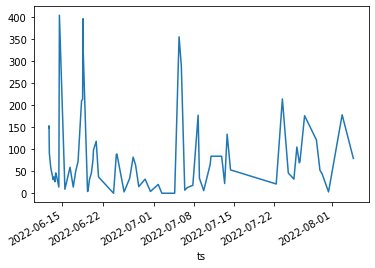

In [17]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x > 0].sum()).plot()

In [18]:
drivers_a.groupby('ts')['12 Hour'].agg(lambda x: x[x < 0].sum()).abs()

ts
2022-06-12 15:42:57    107
2022-06-12 15:52:24    107
2022-06-12 17:10:49     57
2022-06-12 23:24:40     32
2022-06-13 09:07:54     17
                      ... 
2022-07-29 22:34:47    107
2022-07-30 07:31:19    105
2022-07-31 10:27:56      0
2022-08-02 19:26:41    118
2022-08-04 18:22:43     56
Name: 12 Hour, Length: 71, dtype: int64